# Ön Bilgi
**Geliştiren :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesi Adı :** Iphone Tweet

**Veri Kümesinin İçeriği :** 2 farklı sınıfa ait toplamda 533 tweet.

**Tweet Sınıfları :** 

0. Olumsuz
1. Olumlu

**Algoritma :** Decision Tree (DT)

**Doğruluk Oranı :** ~%85


---



In [1]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Sets/iphone.csv", sep=',')
df

,TWEET,CLASS
0,loving my new #iphone6,1
1,iphone 6 + in full effect at tag all day; ever...,1
2,#win an #iphone6 sweepstakes http://t.co/r7mya...,1
3,early morning i phone masters training!! #appl...,1
4,remote control iphone 6 http://t.co/nncexfdgf6...,-1
...,...,...
527,so i cracked my phones screen. #iphone6 #broke...,-1
528,@getrhinoshield any idea when will you ship th...,-1
529,like you got a iphone6 and a black in your mou...,1
530,i was due for an upgrade 2 months ago... why h...,-1


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silelim

In [3]:
df.isnull().sum()

TWEET    0
CLASS    0
dtype: int64

In [4]:
# NULL Değer Bulunmuyor.
# df = df.dropna().reset_index(drop=True)
# df.isnull().sum()

### Gereksiz Verileri Kaldıralım

In [5]:
nltk.download('stopwords')
stop_word_list = stopwords.words('english')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [6]:
def preprocess_text(sen):
    
    # URL Silme İşlemi
    sentence = re.sub(r'http\S+', '', str(sen))

    # E-Mail Adresi Silme İşlemi
    sentence = re.sub('\S+@\S+', '', str(sentence))

    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sentence))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [7]:
x = df['TWEET']
y = df['CLASS']

In [8]:
x = x.apply(preprocess_text)
pd.DataFrame(x)

,TWEET
0,loving new iphone
1,iphone full effect tag day everyday maclife ap...
2,win iphone sweepstakes
3,early morning phone masters training apple iphone
4,remote control iphone ios mobile apple iphone ...
...,...
527,cracked phones screen iphone brokenscreen sad ...
528,getrhinoshield idea ship order today broke iph...
529,like got iphone black mouth dont tell dont got...
530,due upgrade months ago gotten iphone


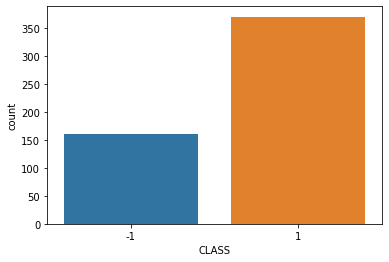

In [9]:
sns.countplot(y)

# Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  


---


**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. İstenilmeyen hatalar engeller ve daha hızlı çalışmasını sağlar. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [10]:
pd.DataFrame(y).sample(5)

,CLASS
423,1
98,1
101,1
230,1
335,1


In [11]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
98,1
30,0
17,0
86,1
514,1


In [12]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1
491,0.0,1.0
461,0.0,1.0
239,0.0,1.0
115,1.0,0.0
512,0.0,1.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [14]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (425,)
x Test : (107,)
y Train : (425, 2)
y Test : (107, 2)


# X Verilerimizi Vektörlere Dönüştürelim (Bag Of Words) : 

---


In [15]:
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [16]:
features = vectorizer.get_feature_names()
BoW_Matrix = x_train.toarray()
BoW_df = pd.DataFrame(BoW_Matrix, columns = features)
BoW_df.head()

,_megan_lucas,aba,abg_jebat,able,absolute,absolutely,accessory,accommodating,accurate,ache,activate,actually,addicted,adding,adjusting,advanced,aexmo,af,aggro,agnes,ago,aint,albdamn,album,alert,allaboutthatbass,almost,already,also,always,amazing,amount,andrewareoff,android,androidsucks,angelic,annoyed,annoying,annoys,another,...,wozniak,writing,wrong,wrote,wtf,xcom,xephemeralstar,xmas,xmaswhere,xperia,xterms,ya,yaaaay,yaay,yahootech,yall,yasss,yasssss,yay,yea,yeah,year,years,yes,yesss,yesterday,yet,yo,york,youll,younger,youve,yr,yrs,yt,yup,zacdixon,ziying,zoned,zz
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Eğitime Başlayalım : 

---


In [17]:
model = DecisionTreeClassifier(random_state = 42, max_features='auto', max_leaf_nodes=60)
model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=60,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [18]:
print('Accuracy = ' + str(accuracy_score(y_test, model.predict(x_test))))

Accuracy = 0.8598130841121495


# Sonuçları Değerlendirelim :

---


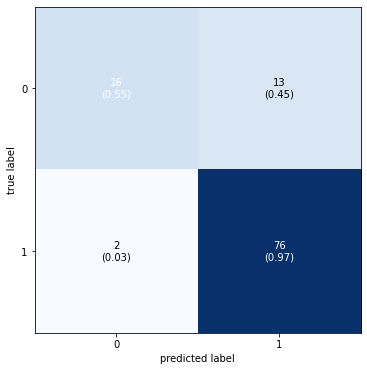

In [19]:
y_pred = model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat = cm,
                                show_normed = True,
                                figsize = (6,6))